EDA

# Load Library

In [1]:
# Load Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import average_precision_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from collections import Counter
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')



# Load Datasets

In [2]:
# Load datasets
df_customer_churn = pd.read_excel('CustomerChurn.xlsx')
df_telco_customer_churn = pd.read_excel('Telco_customer_churn.xlsx')
df_telco_customer_churn_demographics = pd.read_excel('Telco_customer_churn_demographics.xlsx')
df_telco_customer_churn_location = pd.read_excel('Telco_customer_churn_location.xlsx')
df_telco_customer_churn_population = pd.read_excel('Telco_customer_churn_population.xlsx')
df_telco_customer_churn_services = pd.read_excel('Telco_customer_churn_services.xlsx')
df_telco_customer_churn_status = pd.read_excel('Telco_customer_churn_status.xlsx')

# Rename the columns so that the primary key is the same
df_telco_customer_churn.rename(columns = {'CustomerID':'Customer ID'}, inplace = True)

# drop the count column from all datasets
df_telco_customer_churn.drop(['Count'], axis=1, inplace=True)
df_telco_customer_churn_demographics.drop(['Count'], axis=1, inplace=True)
df_telco_customer_churn_location.drop(['Count'], axis=1, inplace=True)
df_telco_customer_churn_services.drop(['Count'], axis=1, inplace=True)
df_telco_customer_churn_status.drop(['Count'], axis=1, inplace=True)


In [3]:
# Print the columns of each dataset
print(df_customer_churn.columns)
print(df_telco_customer_churn.columns)
print(df_telco_customer_churn_demographics.columns)
print(df_telco_customer_churn_location.columns)
print(df_telco_customer_churn_population.columns)
print(df_telco_customer_churn_services.columns)
print(df_telco_customer_churn_status.columns)

# count rows for each dataset
print(df_customer_churn.shape)
print(df_telco_customer_churn.shape)
print(df_telco_customer_churn_demographics.shape)
print(df_telco_customer_churn_location.shape)
print(df_telco_customer_churn_population.shape)
print(df_telco_customer_churn_services.shape)
print(df_telco_customer_churn_status.shape)

Index(['LoyaltyID', 'Customer ID', 'Senior Citizen', 'Partner', 'Dependents',
       'Tenure', 'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn'],
      dtype='object')
Index(['Customer ID', 'Country', 'State', 'City', 'Zip Code', 'Lat Long',
       'Latitude', 'Longitude', 'Gender', 'Senior Citizen', 'Partner',
       'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines',
       'Internet Service', 'Online Security', 'Online Backup',
       'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
       'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges',
       'Total Charges', 'Churn Label', 'Churn Value', 'Churn Score', 'CLTV',
       'Churn Reason'],
      dtype='object')
Index(['Customer ID', 'Gender', 'Age', '

# Dataset Clean

In [4]:
#Merge datasets except for df_telco_customer_churn_population into one big dataset using CustomerID as the key, and remove duplicate columns
# Merge datasets into one big dataset using CustomerID as the key
df = pd.merge(df_telco_customer_churn, df_telco_customer_churn_demographics, on='Customer ID', how='left')
df = pd.merge(df, df_telco_customer_churn_location, on='Customer ID', how='left')
df = pd.merge(df, df_telco_customer_churn_services, on='Customer ID', how='left')
df = pd.merge(df, df_telco_customer_churn_status, on='Customer ID', how='left')


# Remove _x and _y suffix, and drop duplicate columns
df.columns = df.columns.str.replace('_x', '')
df.columns = df.columns.str.replace('_y', '')

# Identify and drop duplicate columns
df = df.loc[:, ~df.columns.duplicated()]

# count distinct column values for each column
df.nunique()

# Drop unnecessary columns: (too granular, don't provide additional information, or similar to other category)
df.drop(['Customer ID','Country','Lat Long', 'Latitude','City','State','Zip Code','Location ID','Service ID','Status ID', 'Longitude', 'Churn Label','Quarter','Internet Type', 'Churn Reason'], axis=1, inplace=True)

In [5]:
# Check for missing values
# Check for missing values in df
missing_values = df.isnull().sum()
rows_with_missing_values = df.isnull().any(axis=1).sum()

with pd.option_context('display.max_rows', None):
    # Check for missing values in df
    missing_values = df.isnull().sum()
    rows_with_missing_values = df.isnull().any(axis=1).sum()

    # Display the results
    print("Categories with Missing Values:")
    print(missing_values)


Categories with Missing Values:
Gender                                  0
Senior Citizen                          0
Partner                                 0
Dependents                              0
Tenure Months                           0
Phone Service                           0
Multiple Lines                          0
Internet Service                        0
Online Security                         0
Online Backup                           0
Device Protection                       0
Tech Support                            0
Streaming TV                            0
Streaming Movies                        0
Contract                                0
Paperless Billing                       0
Payment Method                          0
Monthly Charges                         0
Total Charges                           0
Churn Value                             0
Churn Score                             0
CLTV                                    0
Age                                     0
Un

In [6]:
# Rows that have missing values: Total Charges, Offer, Churn Reason, Churn Category
# Drop rows with missing total charges since there are only 11 of them
df = df.dropna(subset=['Total Charges'])

# fill null values with 'None' when a customer didn't receive any offers
df['Offer'] = df['Offer'].fillna('None')

# fill null values with 'did not churn' for Churn Category
df['Churn Category'] = df['Churn Category'].fillna('Did Not Churn')

In [7]:
df

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Streaming Music,Unlimited Data,Monthly Charge,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score,Customer Status,Churn Category
0,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,...,No,Yes,53.85,0.00,0,20.94,129.09,1,Churned,Competitor
1,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,...,No,Yes,70.70,0.00,0,18.24,169.89,2,Churned,Other
2,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,...,Yes,Yes,99.65,0.00,0,97.20,917.70,3,Churned,Other
3,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,...,Yes,Yes,104.80,0.00,0,136.92,3182.97,3,Churned,Other
4,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,...,Yes,Yes,103.70,0.00,0,2172.17,7208.47,1,Churned,Competitor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Female,No,No,No,72,Yes,No,No,No internet service,No internet service,...,No,No,21.15,19.31,0,1639.44,3039.53,5,Stayed,Did Not Churn
7039,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,...,Yes,Yes,84.80,48.23,0,865.20,2807.47,3,Stayed,Did Not Churn
7040,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,...,Yes,Yes,103.20,45.38,0,2135.52,9453.04,4,Stayed,Did Not Churn
7041,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,...,No,Yes,29.60,27.24,0,0.00,319.21,4,Stayed,Did Not Churn


# EDA

In [8]:

# 'Total Refunds', 'Total Extra Data Charges', 'Tenure in Months'
numerical_cols = ['Tenure Months', 'Monthly Charges', 'Total Charges', 'CLTV', 'Age', 'Avg Monthly Long Distance Charges',
 'Avg Monthly GB Download', 'Monthly Charge', 'Total Long Distance Charges', 'Total Revenue']

categorical_cols = ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service',
 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
 'Under 30', 'Married', 'Referred a Friend', 'Offer', 'Device Protection Plan', 'Premium Tech Support', 'Streaming Music', 'Unlimited Data','Satisfaction Score',
 'Number of Dependents', 'Number of Referrals']

Other_Churn_Flags =['Churn Score', 'Churn Value', 'Customer Status', 'Churn Category']

In [9]:
df['Churn Value'] = df['Churn Value'].apply(lambda x: 'Churned' if x == 1 else 'Not Churned')
df['Churn Value']

0           Churned
1           Churned
2           Churned
3           Churned
4           Churned
           ...     
7038    Not Churned
7039    Not Churned
7040    Not Churned
7041    Not Churned
7042    Not Churned
Name: Churn Value, Length: 7043, dtype: object

Text(0.5, 1.0, 'Pie Chart of Churn Value Distribution')

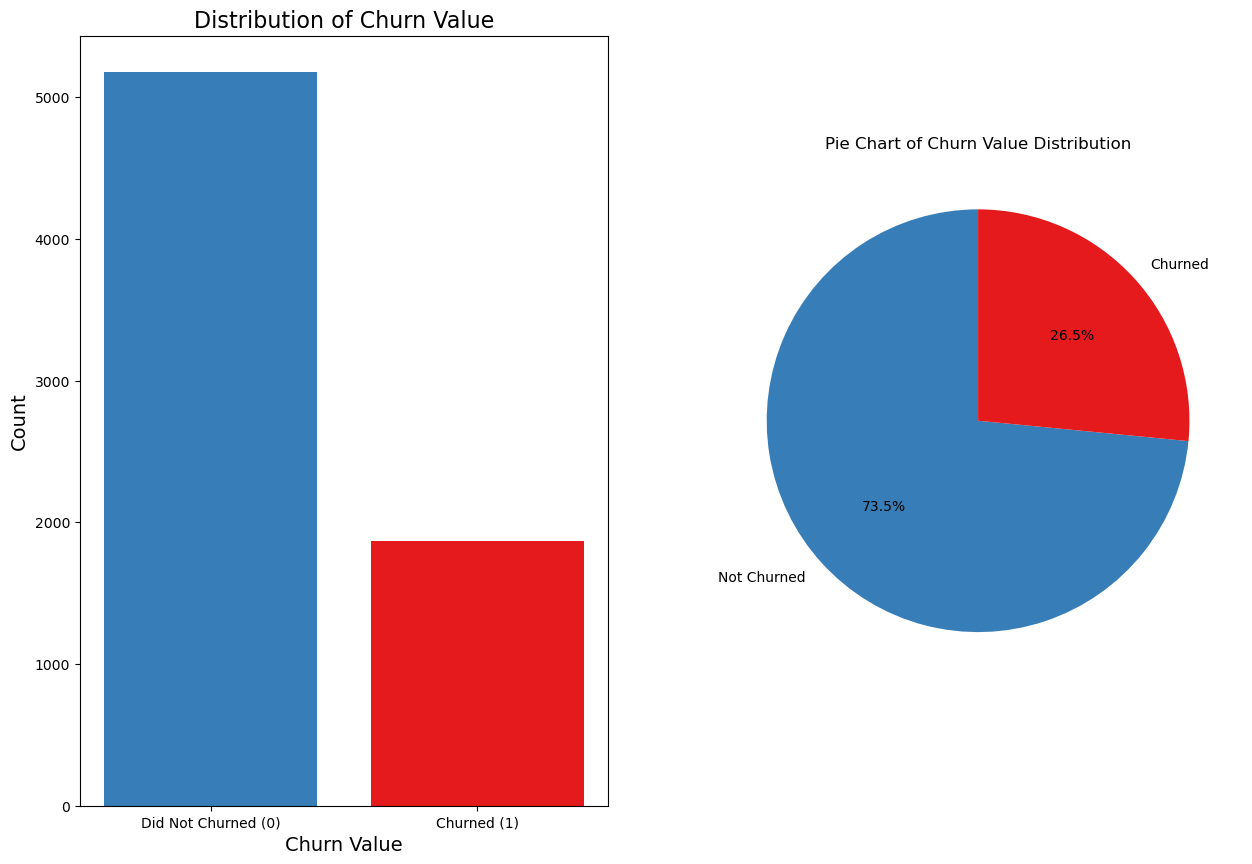

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
churn_counts = df['Churn Value'].value_counts()

axes[0].bar(churn_counts.index, churn_counts.values, color = [sns.color_palette('Set1')[1], sns.color_palette('Set1')[0]])
axes[0].set_title("Distribution of Churn Value", fontsize=16)
axes[0].set_xlabel("Churn Value", fontsize=14)
axes[0].set_ylabel("Count", fontsize=14)
axes[0].set_xticklabels(['Did Not Churned (0)', 'Churned (1)'])

axes[1].pie(churn_counts.tolist(), labels = churn_counts.index.tolist(), colors = [sns.color_palette('Set1')[1],
                                                                                   sns.color_palette('Set1')[0]],
         autopct='%.1f%%', startangle = 90)
axes[1].set_title(f"Pie Chart of Churn Value Distribution")

# Categorical

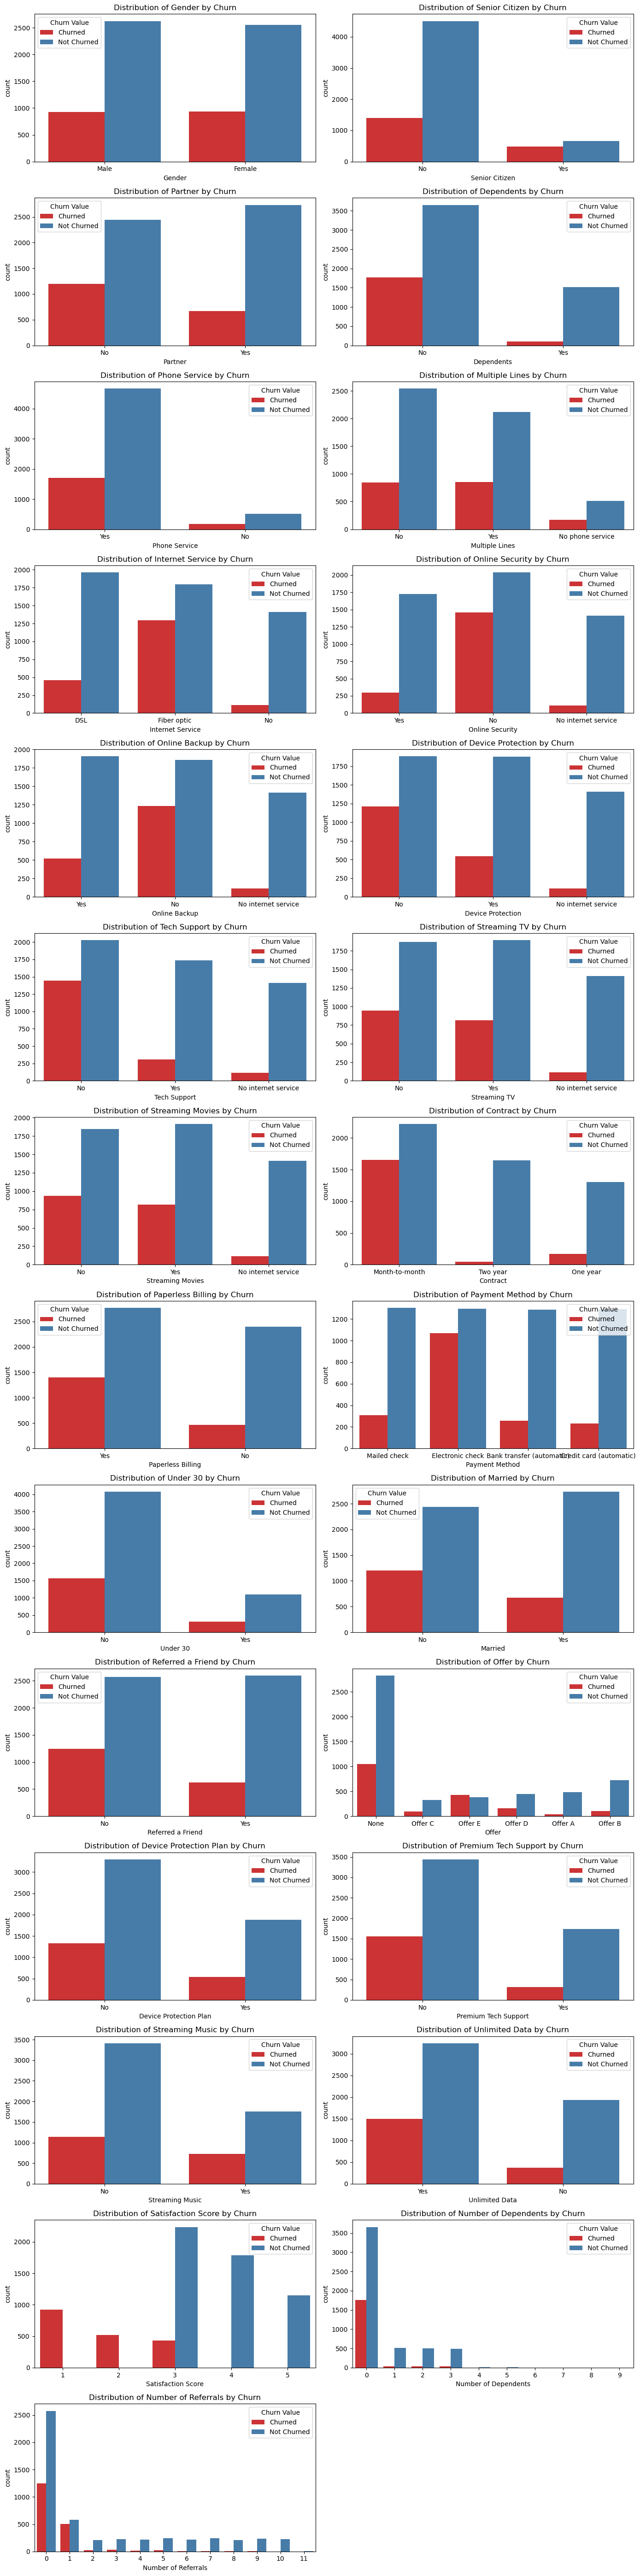

In [11]:
num_categorical_cols = len(categorical_cols)
num_rows_cat = math.ceil(num_categorical_cols / 2)
custom_palette = {'Not Churned': sns.color_palette('Set1')[1], 'Churned': sns.color_palette('Set1')[0]}

plt.figure(figsize=(14, num_rows_cat * 4))
for idx, col in enumerate(categorical_cols):
    plt.subplot(num_rows_cat, 2, idx + 1)
    sns.countplot(data=df, x=col, hue='Churn Value', palette=custom_palette)
    plt.title(f'Distribution of {col} by Churn')
    plt.xticks(rotation=0)
    plt.tight_layout()
plt.show()

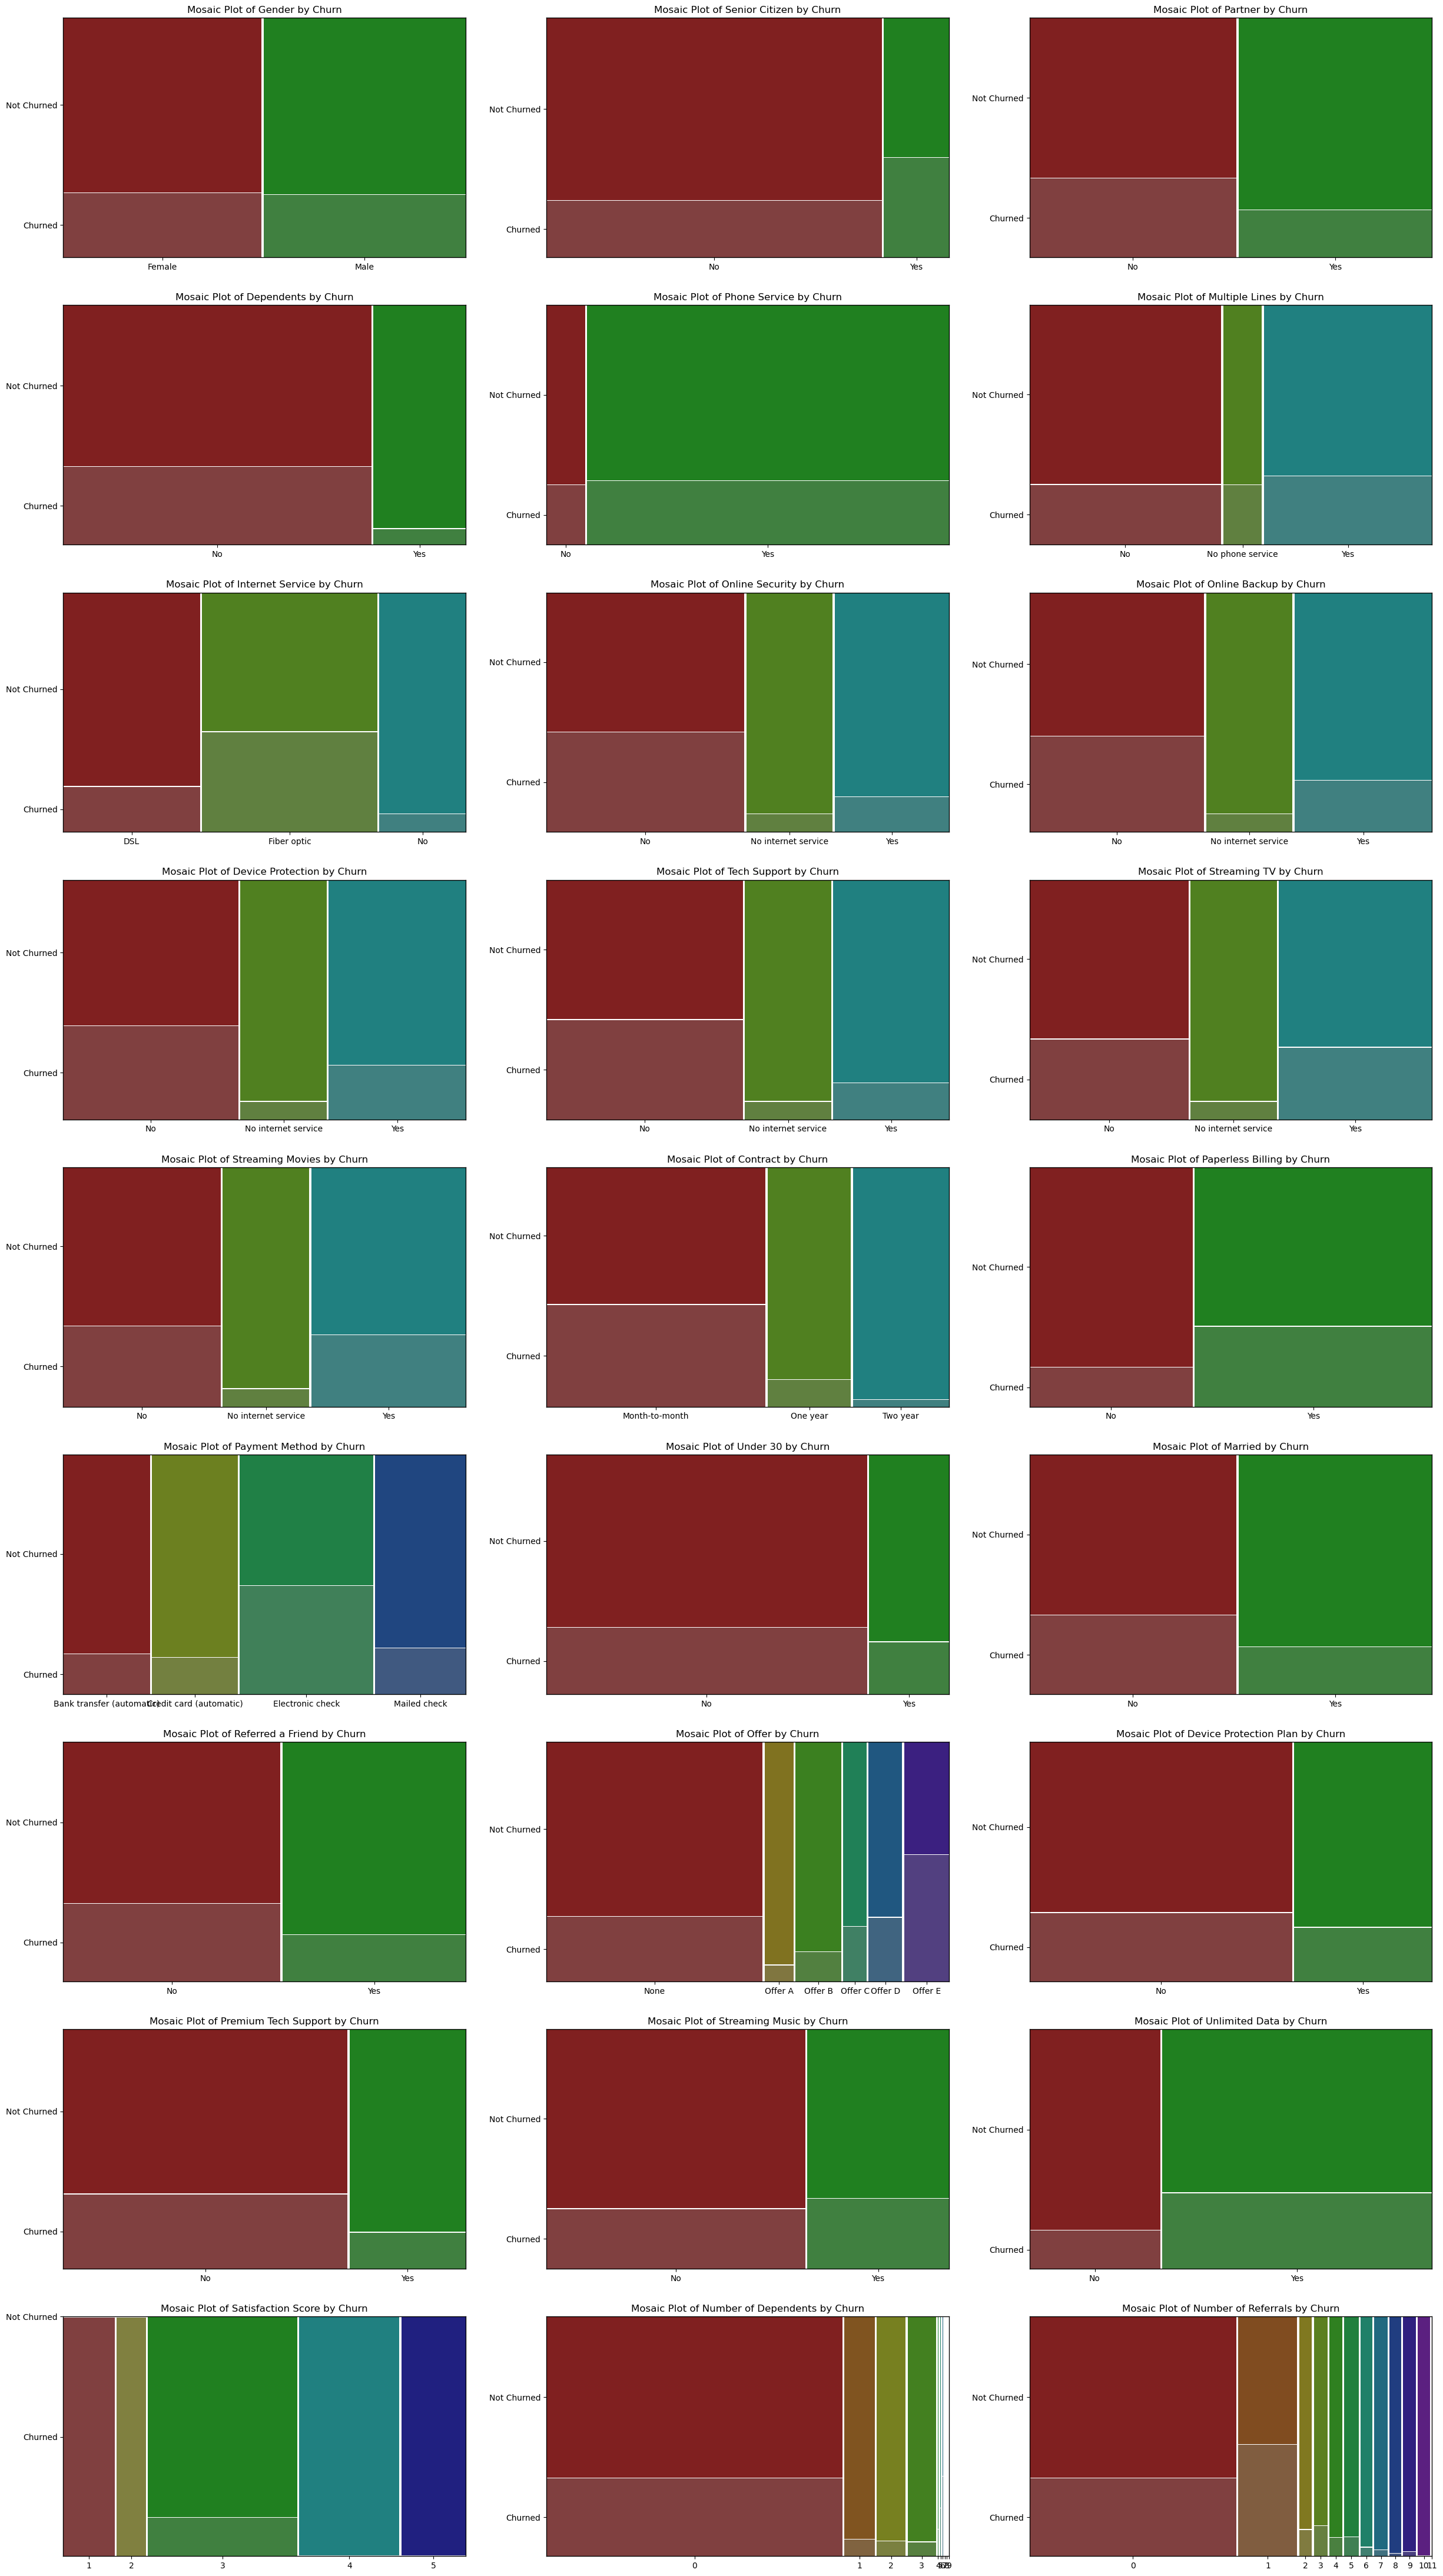

In [12]:
# https://www.statsmodels.org/stable/generated/statsmodels.graphics.mosaicplot.mosaic.html

fig, axes = plt.subplots(9, 3, figsize=(30, num_rows_cat * 4))
axes_idx = 0
axes_graph_idx = 0

for idx, col in enumerate(categorical_cols):
    col_churn = df.groupby([col, 'Churn Value']).size().to_dict()
    mosaic(col_churn, ax=axes[axes_idx][axes_graph_idx], title = f'Mosaic Plot of {col} by Churn', axes_label = True,
           labelizer=lambda k: "")

    axes_graph_idx += 1

    if (axes_graph_idx % 3 == 0):
        axes_graph_idx = 0
        axes_idx += 1

plt.show()

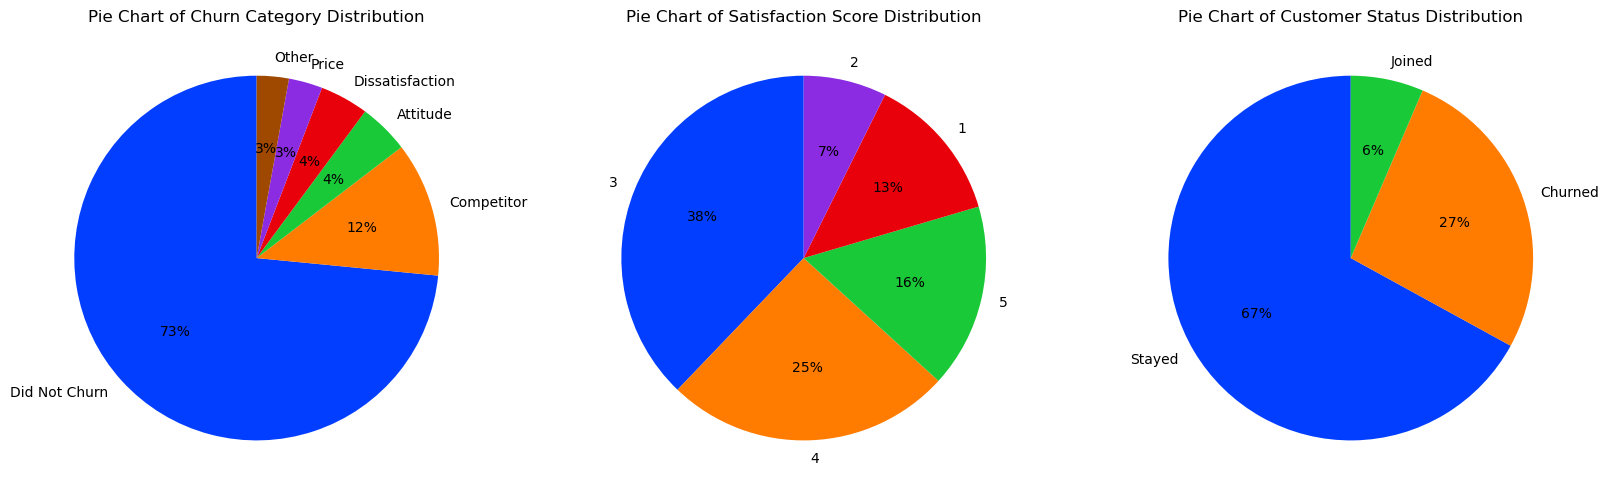

In [13]:
pie_category = ['Churn Category', 'Satisfaction Score', 'Customer Status']
fig, axes = plt.subplots(1, 3, figsize=(20, 20))
idx = 0

for category in pie_category:
    pie_category_freq = df[category].value_counts()

    pie_category_key = pie_category_freq.index.tolist()
    pie_category_data = pie_category_freq.tolist()

    axes[idx].pie(pie_category_data, labels = pie_category_key, colors = sns.color_palette('bright'),
         autopct='%.0f%%', startangle = 90)
    axes[idx].set_title(f"Pie Chart of {category} Distribution")


    idx += 1

plt.show()


# Numerical

In [14]:
# Function to clean numeric columns
def clean_numeric_columns(df, columns):
    for col in columns:
        # Replace any spaces or empty strings with NaN
        df[col] = df[col].replace(" ", None)  # Replacing spaces with None
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, forcing invalid values to NaN
    return df

# Replace inf values with NaN across the entire dataframe
df.replace([float('inf'), float('-inf')], float('nan'), inplace=True)

# Clean numeric columns
df = clean_numeric_columns(df, numerical_cols)

In [15]:
df[numerical_cols]

,Tenure Months,Monthly Charges,Total Charges,CLTV,Age,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Long Distance Charges,Total Revenue
0,2,53.85,108.15,3239,37,10.47,21,53.85,20.94,129.09
1,2,70.70,151.65,2701,19,9.12,51,70.70,18.24,169.89
2,8,99.65,820.50,5372,31,12.15,26,99.65,97.20,917.70
3,28,104.80,3046.05,5003,23,4.89,47,104.80,136.92,3182.97
4,49,103.70,5036.30,5340,38,44.33,11,103.70,2172.17,7208.47
...,...,...,...,...,...,...,...,...,...,...
7038,72,21.15,1419.40,5306,30,22.77,0,21.15,1639.44,3039.53
7039,24,84.80,1990.50,2140,38,36.05,24,84.80,865.20,2807.47
7040,72,103.20,7362.90,5560,30,29.66,59,103.20,2135.52,9453.04
7041,11,29.60,346.45,2793,32,0.00,17,29.60,0.00,319.21


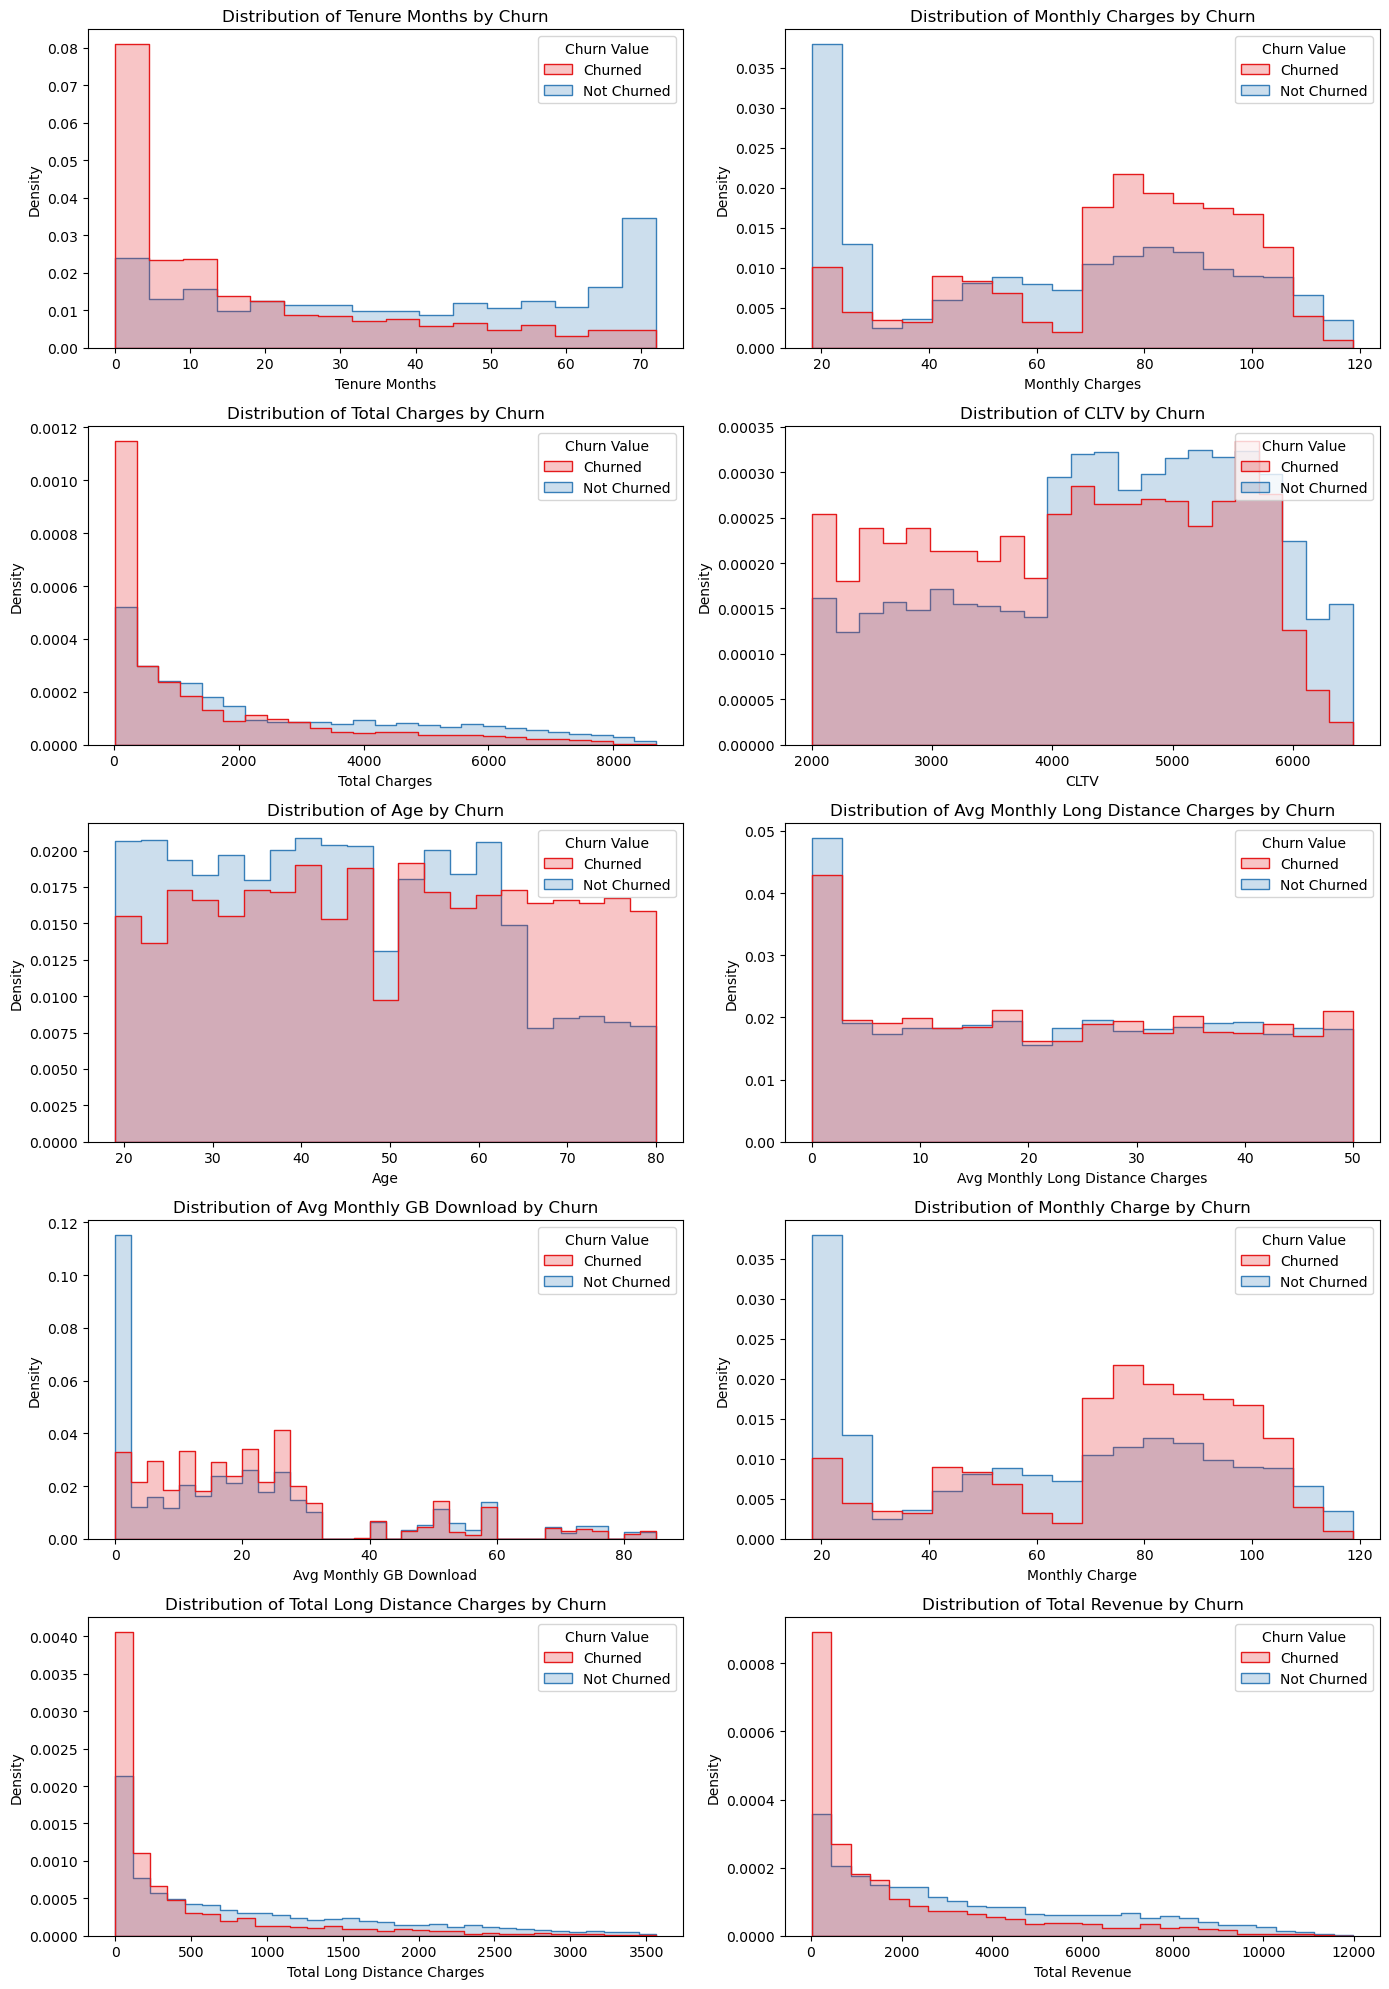

In [16]:
# Plot distribution for numerical columns
num_numerical_cols = len(numerical_cols)
num_rows_num = math.ceil(num_numerical_cols / 2)

plt.figure(figsize=(14, num_rows_num * 4))
for idx, col in enumerate(numerical_cols):
    plt.subplot(num_rows_num, 2, idx + 1)
    sns.histplot(data=df, x=col, hue='Churn Value', element="step", stat="density", common_norm=False, palette=custom_palette)
    plt.title(f'Distribution of {col} by Churn')
    plt.tight_layout()
plt.show()

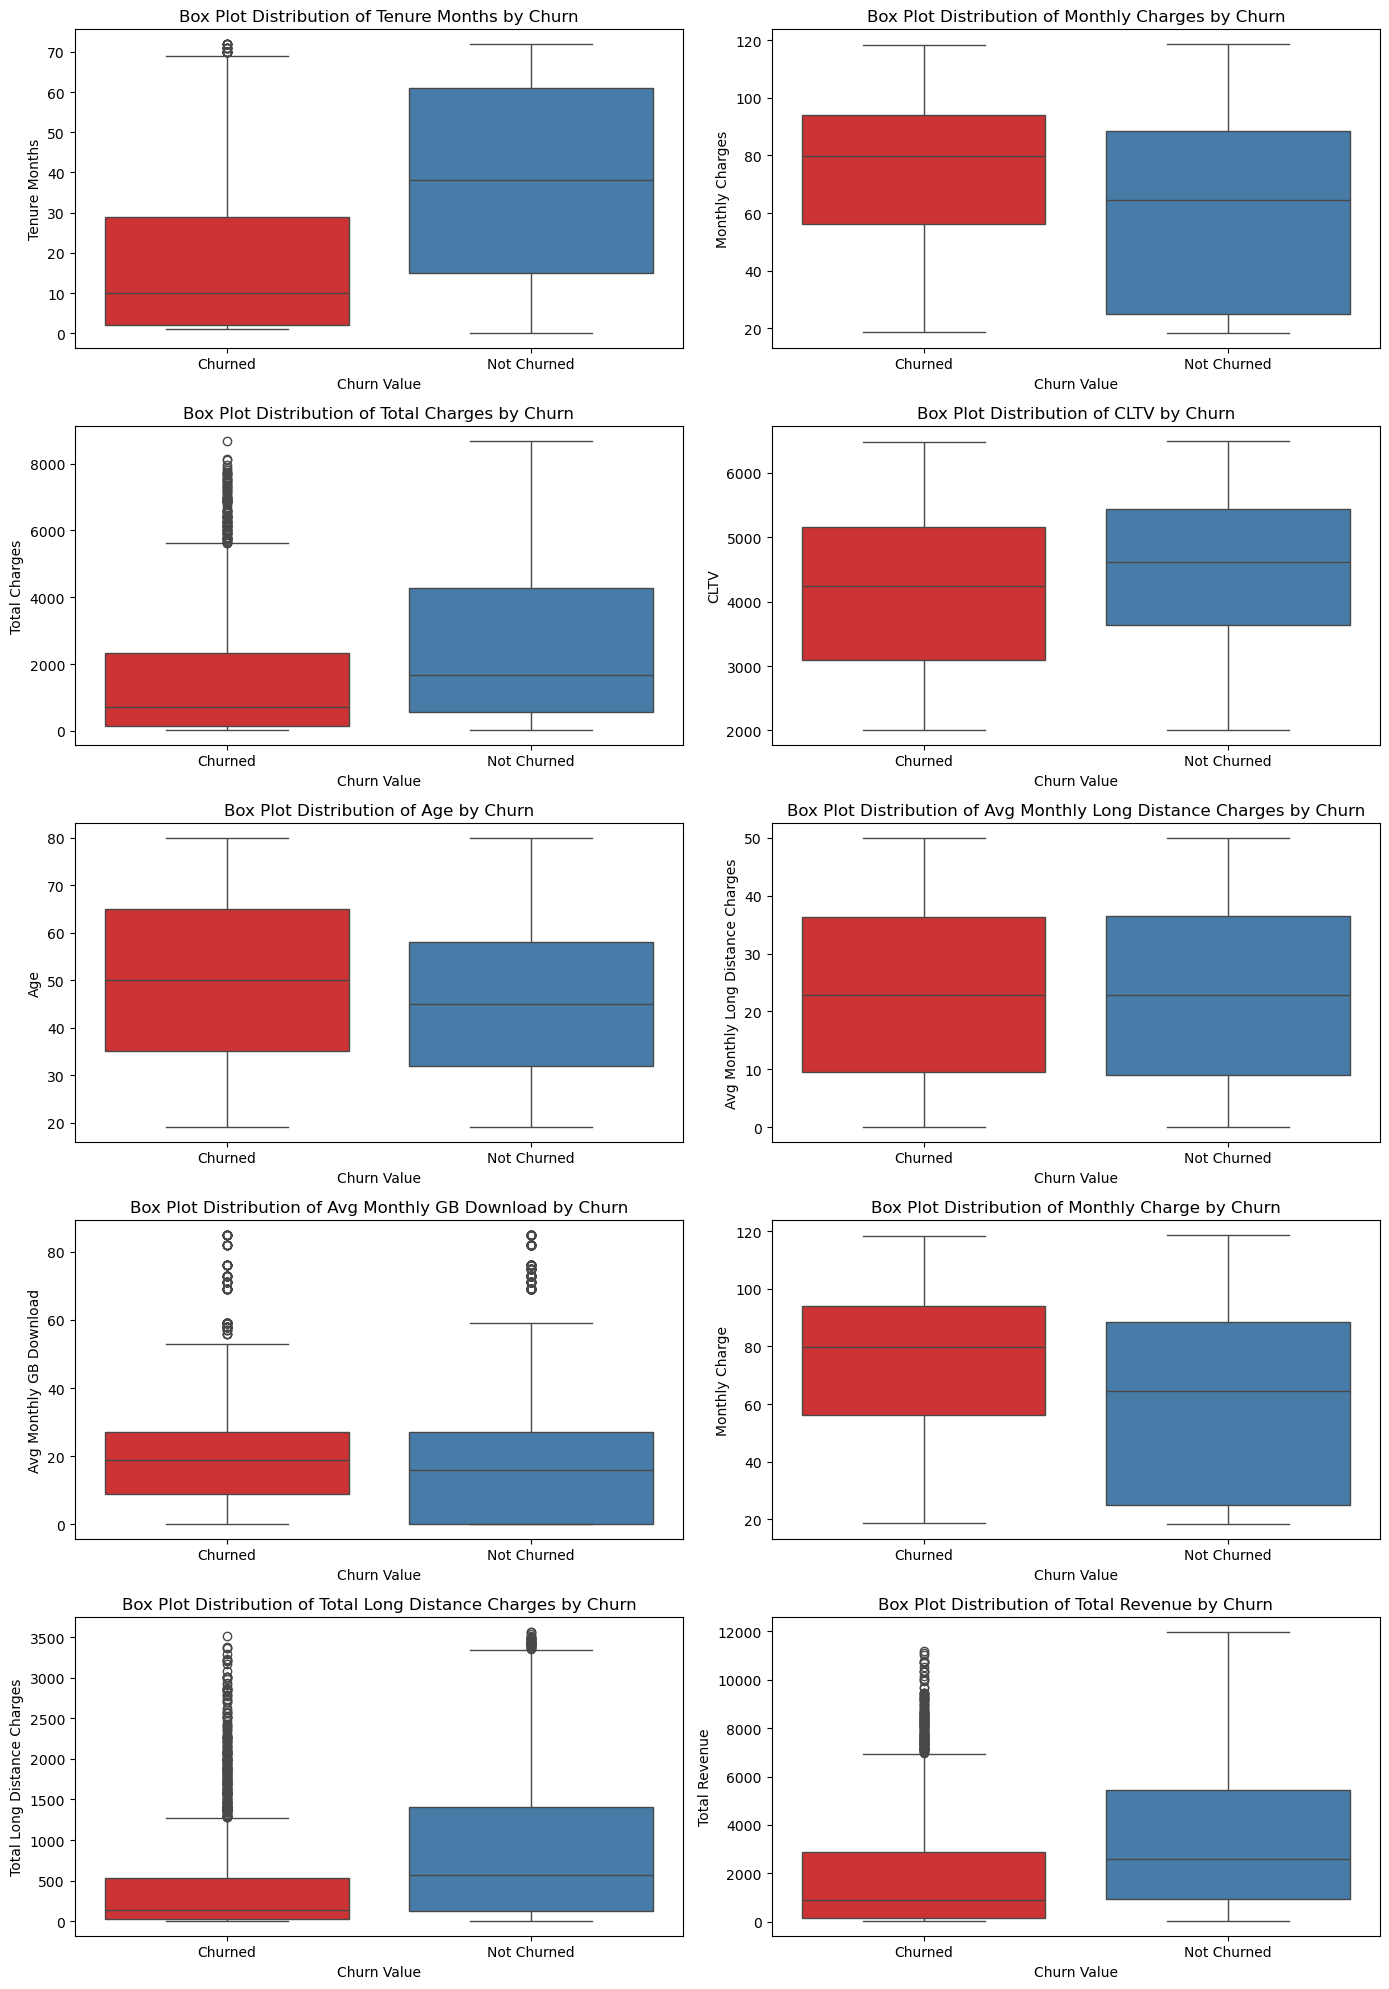

In [17]:
num_numerical_cols = len(numerical_cols)
num_rows_num = math.ceil(num_numerical_cols / 2)

plt.figure(figsize=(14, num_rows_num * 4))
for idx, col in enumerate(numerical_cols):
    plt.subplot(num_rows_num, 2, idx + 1)
    sns.boxplot(data = df, x = "Churn Value", y= col, hue = "Churn Value", palette=custom_palette)
    plt.title(f'Box Plot Distribution of {col} by Churn')
    plt.tight_layout()
plt.show()

In [18]:
df[numerical_cols]

,Tenure Months,Monthly Charges,Total Charges,CLTV,Age,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Long Distance Charges,Total Revenue
0,2,53.85,108.15,3239,37,10.47,21,53.85,20.94,129.09
1,2,70.70,151.65,2701,19,9.12,51,70.70,18.24,169.89
2,8,99.65,820.50,5372,31,12.15,26,99.65,97.20,917.70
3,28,104.80,3046.05,5003,23,4.89,47,104.80,136.92,3182.97
4,49,103.70,5036.30,5340,38,44.33,11,103.70,2172.17,7208.47
...,...,...,...,...,...,...,...,...,...,...
7038,72,21.15,1419.40,5306,30,22.77,0,21.15,1639.44,3039.53
7039,24,84.80,1990.50,2140,38,36.05,24,84.80,865.20,2807.47
7040,72,103.20,7362.90,5560,30,29.66,59,103.20,2135.52,9453.04
7041,11,29.60,346.45,2793,32,0.00,17,29.60,0.00,319.21


In [19]:
for col in numerical_cols:
    print(f"Before clipping, {col}: {df[col].describe()}")
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[col] = df[col].apply(lambda x: min(max(x, lower_bound), upper_bound))
    
    print(f"After clipping, {col}: {df[col].describe()}")

Before clipping, Tenure Months: count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: Tenure Months, dtype: float64
After clipping, Tenure Months: count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: Tenure Months, dtype: float64
Before clipping, Monthly Charges: count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: Monthly Charges, dtype: float64
After clipping, Monthly Charges: count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: Monthly Charges, dtype: float64
Before clipping, Total Charges: count    7032.0000

In [20]:
df

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Streaming Music,Unlimited Data,Monthly Charge,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score,Customer Status,Churn Category
0,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,...,No,Yes,53.85,0.00,0,20.94,129.09,1,Churned,Competitor
1,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,...,No,Yes,70.70,0.00,0,18.24,169.89,2,Churned,Other
2,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,...,Yes,Yes,99.65,0.00,0,97.20,917.70,3,Churned,Other
3,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,...,Yes,Yes,104.80,0.00,0,136.92,3182.97,3,Churned,Other
4,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,...,Yes,Yes,103.70,0.00,0,2172.17,7208.47,1,Churned,Competitor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Female,No,No,No,72,Yes,No,No,No internet service,No internet service,...,No,No,21.15,19.31,0,1639.44,3039.53,5,Stayed,Did Not Churn
7039,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,...,Yes,Yes,84.80,48.23,0,865.20,2807.47,3,Stayed,Did Not Churn
7040,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,...,Yes,Yes,103.20,45.38,0,2135.52,9453.04,4,Stayed,Did Not Churn
7041,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,...,No,Yes,29.60,27.24,0,0.00,319.21,4,Stayed,Did Not Churn


In [21]:
# from sklearn.preprocessing import LabelEncoder
# def object_to_int(dataframe_series):
#     if dataframe_series.dtype=='object':
#         dataframe_series = LabelEncoder().fit_transform(dataframe_series)
#     return dataframe_series

# df = df.apply(lambda x: object_to_int(x))

# Data Splitting and Pre-processing

In [22]:
df.head()

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Streaming Music,Unlimited Data,Monthly Charge,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score,Customer Status,Churn Category
0,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,...,No,Yes,53.85,0.0,0,20.94,129.09,1,Churned,Competitor
1,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,...,No,Yes,70.70,0.0,0,18.24,169.89,2,Churned,Other
2,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,...,Yes,Yes,99.65,0.0,0,97.20,917.70,3,Churned,Other
3,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,...,Yes,Yes,104.80,0.0,0,136.92,3182.97,3,Churned,Other
4,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,...,Yes,Yes,103.70,0.0,0,2172.17,7208.47,1,Churned,Competitor


In [23]:
# plt.figure(figsize=(14,7))
# df.corr()['Churn Value'].sort_values(ascending = False)

In [24]:
df_x = df.drop(columns=['Churn Value'])
df_y = df['Churn Value']

In [25]:
# split to 80/20
x_dev, x_test, y_dev, y_test = train_test_split(df_x, df_y, stratify = df_y, test_size = 0.2, random_state = 42)


In [26]:
print("x_dev Shape: ", x_dev.shape)
print("x_test Shape: ", x_test.shape, "\n")

print("y_dev Shape: ", y_dev.shape)
print("y_test Shape: ", y_test.shape, "\n")

x_dev Shape:  (5634, 43)
x_test Shape:  (1409, 43) 

y_dev Shape:  (5634,)
y_test Shape:  (1409,) 



In [27]:
# This was used to help decide what feature goes to what encoder
# for categorical in categorical_cols:
#     print("Category: ", categorical)
#     print(len(sorted(df[categorical].unique())))
#     print(sorted(df[categorical].unique()), "\n")

# for categorical in Other_Churn_Flags:
#     print("Category: ", categorical)
#     print(len(sorted(df[categorical].unique())))
#     print(sorted(df[categorical].unique()), "\n")

In [28]:
ordinal_categorical = ['Contract', 'Offer', 'Satisfaction Score', 'Number of Dependents', 'Number of Referrals', 'Customer Status']
one_hot_categorical = []

for categorical in categorical_cols:
    if categorical not in ordinal_categorical:
        one_hot_categorical.append(categorical)

one_hot_categorical.append('Churn Category')


In [29]:
for ordinal_category in ordinal_categorical:
    sorted_ordinal = [sorted(x_dev[ordinal_category].unique())]
    ordinal_encoder = OrdinalEncoder(categories = sorted_ordinal)

    x_dev[f"{ordinal_category}_ord"] = ordinal_encoder.fit_transform(x_dev[[ordinal_category]])
    x_test[f"{ordinal_category}_ord"] = ordinal_encoder.transform(x_test[[ordinal_category]])

x_dev = x_dev.drop(columns = ordinal_categorical)
x_test = x_test.drop(columns = ordinal_categorical)

In [30]:
print("x_dev Shape: ", x_dev.shape)
print("x_test Shape: ", x_test.shape)

x_dev Shape:  (5634, 43)
x_test Shape:  (1409, 43)


In [31]:
x_dev = pd.get_dummies(x_dev, columns = one_hot_categorical, drop_first = True, dtype=int)
x_test = pd.get_dummies(x_test, columns = one_hot_categorical, drop_first = True, dtype=int)

In [32]:
print("x_dev Shape: ", x_dev.shape)
print("x_test Shape: ", x_test.shape)

x_dev Shape:  (5634, 57)
x_test Shape:  (1409, 57)


In [33]:
numerical_cols.append("Churn Score")

x_dev[numerical_cols] = x_dev[numerical_cols].apply(pd.to_numeric, errors='coerce')
x_test[numerical_cols] = x_test[numerical_cols].apply(pd.to_numeric, errors='coerce')

In [34]:
from sklearn.impute import KNNImputer 

# impute any missing value in our numerical column
imputer = KNNImputer(n_neighbors=5)
x_dev[numerical_cols] = imputer.fit_transform(x_dev[numerical_cols])
x_test[numerical_cols] = imputer.transform(x_test[numerical_cols]) 

In [35]:
from sklearn.preprocessing import PowerTransformer

# Make each numerical features normally distributed
pt = PowerTransformer(method='yeo-johnson') 
x_dev[numerical_cols] = pt.fit_transform(x_dev[numerical_cols]) 
x_test[numerical_cols] = pt.transform(x_test[numerical_cols])   

# x_dev[numerical_cols] = np.log1p(x_dev[numerical_cols]) 
# x_test[numerical_cols] = np.log1p(x_test[numerical_cols])

In [36]:
# Provided that we are using decision tree as our baseline and using Random Forest and XG Boost for our model, we will use Min Max Scaler
# as that scale is best for these models
minMax_Scaler = MinMaxScaler()
x_dev[numerical_cols] = minMax_Scaler.fit_transform(x_dev[numerical_cols])
x_test[numerical_cols] = minMax_Scaler.transform(x_test[numerical_cols])

In [37]:
# Check for any correlation
correlation_matrix = x_dev.corr()
correlation_matrix

,Tenure Months,Monthly Charges,Total Charges,Churn Score,CLTV,Age,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,...,Referred a Friend_Yes,Device Protection Plan_Yes,Premium Tech Support_Yes,Streaming Music_Yes,Unlimited Data_Yes,Churn Category_Competitor,Churn Category_Did Not Churn,Churn Category_Dissatisfaction,Churn Category_Other,Churn Category_Price
Tenure Months,1.000000,0.248367,0.903083,-0.232460,0.361416,0.018567,0.976943,0.021170,0.054305,0.248367,...,0.368640,0.358664,0.318372,0.231656,0.027381,-0.235097,0.372233,-0.118046,-0.118098,-0.104339
Monthly Charges,0.248367,1.000000,0.615619,0.129246,0.093275,0.143482,0.247535,0.156580,0.590996,1.000000,...,0.096008,0.483159,0.337863,0.528512,0.588414,0.142843,-0.197401,0.071237,0.061356,0.034312
Total Charges,0.903083,0.615619,1.000000,-0.147099,0.313391,0.070536,0.869401,0.067663,0.314051,0.615619,...,0.336146,0.502622,0.417167,0.408567,0.285113,-0.143953,0.238604,-0.070740,-0.078115,-0.074471
Churn Score,-0.232460,0.129246,-0.147099,1.000000,-0.091478,0.089658,-0.225294,0.024224,0.068400,0.129246,...,-0.112155,-0.053413,-0.113103,0.028555,0.099639,0.414322,-0.659742,0.229320,0.183804,0.199044
CLTV,0.361416,0.093275,0.313391,-0.091478,1.000000,-0.006636,0.404131,0.027419,0.026429,0.093275,...,0.122766,0.122793,0.126156,0.086435,-0.000989,-0.074597,0.141476,-0.051344,-0.061142,-0.043272
Age,0.018567,0.143482,0.070536,0.089658,-0.006636,1.000000,0.011243,-0.005919,-0.220784,0.143482,...,-0.003907,0.026567,-0.039078,-0.152239,0.078960,0.064907,-0.118957,0.039577,0.025465,0.047132
Tenure in Months,0.976943,0.247535,0.869401,-0.225294,0.404131,0.011243,1.000000,0.022730,0.052789,0.247535,...,0.368639,0.361865,0.324554,0.235972,0.027974,-0.223501,0.354504,-0.115169,-0.112964,-0.098937
Avg Monthly Long Distance Charges,0.021170,0.156580,0.067663,0.024224,0.027419,-0.005919,0.022730,1.000000,-0.065468,0.156580,...,0.009003,-0.037797,-0.055711,0.001848,-0.063580,0.017684,-0.014013,-0.010010,-0.010113,0.023962
Avg Monthly GB Download,0.054305,0.590996,0.314051,0.068400,0.026429,-0.220784,0.052789,-0.065468,1.000000,0.590996,...,0.046558,0.314249,0.298377,0.384840,0.588247,0.102070,-0.122730,0.069462,0.031741,-0.014108
Monthly Charge,0.248367,1.000000,0.615619,0.129246,0.093275,0.143482,0.247535,0.156580,0.590996,1.000000,...,0.096008,0.483159,0.337863,0.528512,0.588414,0.142843,-0.197401,0.071237,0.061356,0.034312


In [38]:
# https://stackabuse.com/applying-filter-methods-in-python-for-feature-selection/
# Find all features that return a threshold value greater than or equal to 0.8 to drop
correlated_features = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) >= 0.78:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print(correlated_features)
print(len(correlated_features))

{'Tech Support_No internet service', 'Multiple Lines_No phone service', 'Premium Tech Support_Yes', 'Streaming Music_Yes', 'Married_Yes', 'Total Revenue', 'Tenure in Months', 'Total Charges', 'Referred a Friend_Yes', 'Dependents_Yes', 'Internet Service_No', 'Device Protection_No internet service', 'Streaming TV_No internet service', 'Online Security_No internet service', 'Internet Service_Fiber optic', 'Device Protection Plan_Yes', 'Online Backup_No internet service', 'Monthly Charge', 'Streaming Movies_No internet service', 'Churn Category_Did Not Churn'}
20


In [39]:
x_dev.drop(labels = correlated_features, axis = 1, inplace = True)
x_test.drop(labels = correlated_features, axis = 1, inplace = True)

In [40]:
correlation_matrix = x_dev.corr()
correlation_matrix

,Tenure Months,Monthly Charges,Churn Score,CLTV,Age,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,...,Paperless Billing_Yes,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,Under 30_Yes,Unlimited Data_Yes,Churn Category_Competitor,Churn Category_Dissatisfaction,Churn Category_Other,Churn Category_Price
Tenure Months,1.000000,0.248367,-0.232460,0.361416,0.018567,0.021170,0.054305,0.075702,0.092046,0.642652,...,0.006083,0.239491,-0.206927,-0.242621,-0.005456,0.027381,-0.235097,-0.118046,-0.118098,-0.104339
Monthly Charges,0.248367,1.000000,0.129246,0.093275,0.143482,0.156580,0.590996,0.019890,0.126759,0.303408,...,0.352426,0.020612,0.265443,-0.366212,-0.048588,0.588414,0.142843,0.071237,0.061356,0.034312
Churn Score,-0.232460,0.129246,1.000000,-0.091478,0.089658,0.024224,0.068400,-0.018209,0.005211,-0.126178,...,0.129481,-0.086379,0.182849,-0.053311,-0.052418,0.099639,0.414322,0.229320,0.183804,0.199044
CLTV,0.361416,0.093275,-0.091478,1.000000,-0.006636,0.027419,0.026429,0.011426,0.038518,0.234884,...,0.006172,0.087663,-0.078036,-0.094091,-0.003374,-0.000989,-0.074597,-0.051344,-0.061142,-0.043272
Age,0.018567,0.143482,0.089658,-0.006636,1.000000,-0.005919,-0.220784,0.017637,0.022389,0.017541,...,0.092098,-0.019308,0.120769,-0.125436,-0.712962,0.078960,0.064907,0.039577,0.025465,0.047132
Avg Monthly Long Distance Charges,0.021170,0.156580,0.024224,0.027419,-0.005919,1.000000,-0.065468,-0.020947,0.002079,0.696704,...,0.031068,-0.013877,0.013822,-0.016700,0.002328,-0.063580,0.017684,-0.010010,-0.010113,0.023962
Avg Monthly GB Download,0.054305,0.590996,0.068400,0.026429,-0.220784,-0.065468,1.000000,0.008576,0.124788,-0.042687,...,0.225773,0.001540,0.182691,-0.224774,0.332367,0.588247,0.102070,0.069462,0.031741,-0.014108
Total Refunds,0.075702,0.019890,-0.018209,0.011426,0.017637,-0.020947,0.008576,1.000000,0.008993,0.039837,...,-0.006117,-0.010062,0.017973,-0.031168,-0.012231,0.003866,-0.019467,0.007010,-0.025755,-0.015161
Total Extra Data Charges,0.092046,0.126759,0.005211,0.038518,0.022389,0.002079,0.124788,0.008993,1.000000,0.054551,...,0.040251,0.003435,0.033426,-0.063757,0.013186,-0.393909,-0.008352,0.024250,0.000955,0.000332
Total Long Distance Charges,0.642652,0.303408,-0.126178,0.234884,0.017541,0.696704,-0.042687,0.039837,0.054551,1.000000,...,0.029127,0.138528,-0.121454,-0.161477,-0.010631,-0.053013,-0.139099,-0.080191,-0.076752,-0.048670


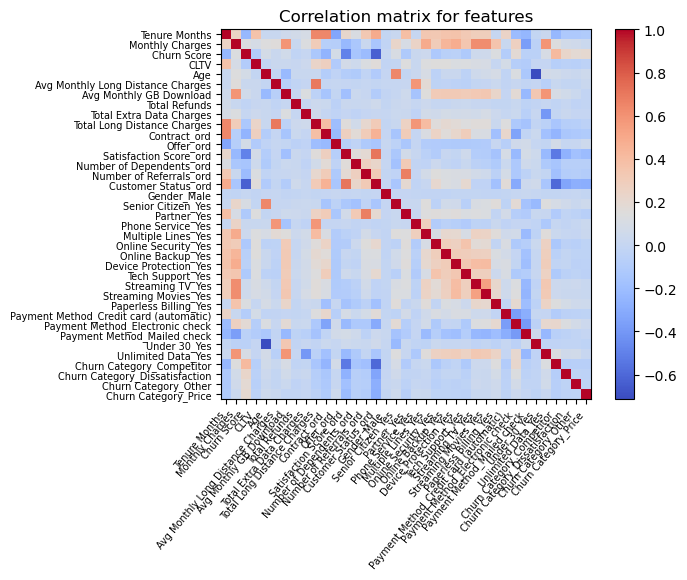

In [41]:
# Generates heat map
plt.imshow(correlation_matrix, cmap = 'coolwarm')

# adding colorbar
plt.colorbar()

# gets the column name for tick labels
tick_labels = [column for column in correlation_matrix.columns]

# adds column label to the heat map 
plt.title("Correlation matrix for features")
plt.xticks(range(len(correlation_matrix)), tick_labels, rotation=50, ha='right', fontsize = 7)
plt.yticks(range(len(correlation_matrix)), tick_labels, fontsize = 7)

plt.show()

In [42]:
print("x_dev Shape: ", x_dev.shape)
print("x_test Shape: ", x_test.shape, "\n")

print("y_dev Shape: ", y_dev.shape)
print("y_test Shape: ", y_test.shape, "\n")

x_dev Shape:  (5634, 37)
x_test Shape:  (1409, 37) 

y_dev Shape:  (5634,)
y_test Shape:  (1409,) 



In [43]:
# # Reason for this is to see this may help prevent work conflict but did not since issue is change in correlation matrix
# import copy 

# x_dev_copy = copy.deepcopy(x_dev) 
# x_test_copy = copy.deepcopy(x_test) 

# y_dev_copy = copy.deepcopy(y_dev) 
# y_test_copy = copy.deepcopy(y_test)

In [44]:
# from sklearn.preprocessing import LabelEncoder

# def object_to_int(dataframe_series):
#     if dataframe_series.dtype=='object':
#         return LabelEncoder().fit_transform(dataframe_series)
#     return dataframe_series 

# x_dev = x_dev.apply(object_to_int)
# x_test = x_test.apply(object_to_int)    

In [45]:
y_dev = y_dev.map(lambda x: 1 if x == 'Churned' else 0) 
y_test = y_test.map(lambda x: 1 if x == 'Churned' else 0)

# Model Building and Training

## Decision Tree Baseline Model - Random Oversampling

Class Distribution After Oversampling: Counter({0: 4139, 1: 4139})

Training ROC AUC: 0.8418

Classification Report on Training Set:
              precision    recall  f1-score   support

           0       0.70      1.00      0.83      4139
           1       1.00      0.58      0.73      4139

    accuracy                           0.79      8278
   macro avg       0.85      0.79      0.78      8278
weighted avg       0.85      0.79      0.78      8278

Test ROC AUC: 0.8352

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      1035
           1       1.00      0.56      0.72       374

    accuracy                           0.88      1409
   macro avg       0.93      0.78      0.82      1409
weighted avg       0.90      0.88      0.87      1409



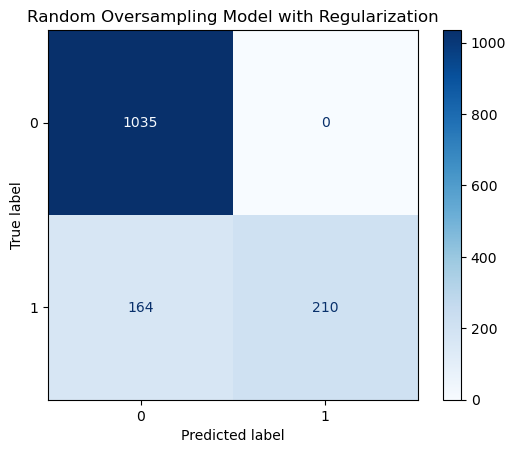

Precision: 0.8632, Recall: 1.0000, F1-Score: 0.9266


In [46]:
ros = RandomOverSampler(random_state=42)
x_resampled_ros, y_resampled_ros = ros.fit_resample(x_dev, y_dev)

print("Class Distribution After Oversampling:", Counter(y_resampled_ros))

classifier = DecisionTreeClassifier(
    max_depth=3,
    min_samples_split=60,
    min_samples_leaf=50,
    max_features="sqrt",
    random_state=42,
    ccp_alpha=0.1
)

scores = cross_validate(
    classifier,
    x_resampled_ros,
    y_resampled_ros,
    cv=5,
    scoring=['roc_auc', 'average_precision']
)

classifier.fit(x_resampled_ros, y_resampled_ros)

y_train_pred = classifier.predict(x_resampled_ros)
y_train_prob = classifier.predict_proba(x_resampled_ros)[:, 1]

roc_auc_train = roc_auc_score(y_resampled_ros, y_train_prob)
print(f"\nTraining ROC AUC: {roc_auc_train:.4f}")

print("\nClassification Report on Training Set:")
print(classification_report(y_resampled_ros, y_train_pred))

y_test_pred = classifier.predict(x_test)
y_test_prob = classifier.predict_proba(x_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_test_prob)
print(f"Test ROC AUC: {roc_auc:.4f}")

print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

conf_matrix = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Random Oversampling Model with Regularization")
plt.show()

# precision = precision_score(y_test, y_test_pred, pos_label='Churned')
# recall = recall_score(y_test, y_test_pred, pos_label='Churned')
# f1 = f1_score(y_test, y_test_pred, pos_label='Churned') 

precision = precision_score(y_test, y_test_pred, pos_label=0)
recall = recall_score(y_test, y_test_pred, pos_label=0)
f1 = f1_score(y_test, y_test_pred, pos_label=0)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

## Decision Tree Baseline Model - SMOTE

SMOTE class distribution: Counter({0: 4139, 1: 4139})
Training ROC AUC: 0.6252
Classification Report on Training Set:
               precision    recall  f1-score   support

           0       0.87      0.29      0.44      4139
           1       0.58      0.96      0.72      4139

    accuracy                           0.63      8278
   macro avg       0.72      0.63      0.58      8278
weighted avg       0.72      0.63      0.58      8278


Decision Tree with SMOTE Results on Test Set:
Confusion Matrix on Test Set:
 [[312 723]
 [ 25 349]]
Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.93      0.30      0.45      1035
           1       0.33      0.93      0.48       374

    accuracy                           0.47      1409
   macro avg       0.63      0.62      0.47      1409
weighted avg       0.77      0.47      0.46      1409



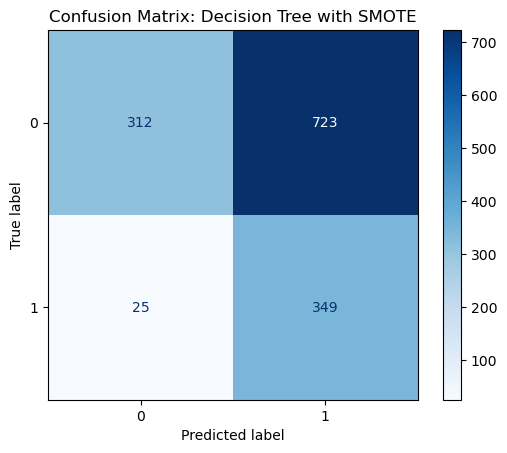

Test ROC AUC: 0.8352
Precision: 0.9258, Recall: 0.3014, F1-Score: 0.4548


In [47]:
smote = SMOTE(random_state=42)
x_resampled_smote, y_resampled_smote = smote.fit_resample(x_dev, y_dev)
print("SMOTE class distribution:", Counter(y_resampled_smote))

dt_smote = DecisionTreeClassifier(
    max_depth=2,
    min_samples_split=15,
    min_samples_leaf=10,
    max_features="sqrt",
    random_state=42,
    ccp_alpha=0.05
)

scores = cross_validate(
    dt_smote,
    x_resampled_smote,
    y_resampled_smote,
    cv=5,
    scoring=['roc_auc', 'average_precision']
)

dt_smote.fit(x_resampled_smote, y_resampled_smote)

y_train_pred = dt_smote.predict(x_resampled_smote)
y_train_prob = dt_smote.predict_proba(x_resampled_smote)[:, 1]
roc_auc_train = roc_auc_score(y_resampled_smote, y_train_prob)

print(f"Training ROC AUC: {roc_auc_train:.4f}")
print("Classification Report on Training Set:\n", classification_report(y_resampled_smote, y_train_pred))

y_pred_smote = dt_smote.predict(x_test)
y_prob_smote = dt_smote.predict_proba(x_test)[:, 1]

print("\nDecision Tree with SMOTE Results on Test Set:")
conf_matrix = confusion_matrix(y_test, y_pred_smote)
print("Confusion Matrix on Test Set:\n", conf_matrix)
print("Classification Report on Test Set:\n", classification_report(y_test, y_pred_smote))

conf_matrix = confusion_matrix(y_test, y_pred_smote)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dt_smote.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Decision Tree with SMOTE")
plt.show()

# roc_auc = roc_auc_score(y_test, y_prob_smote) 
# precision = precision_score(y_test, y_pred_smote, pos_label='Churned')
# recall = recall_score(y_test, y_pred_smote, pos_label='Churned')
# f1 = f1_score(y_test, y_pred_smote, pos_label='Churned') 

precision = precision_score(y_test, y_pred_smote, pos_label=0)
recall = recall_score(y_test, y_pred_smote, pos_label=0)
f1 = f1_score(y_test, y_pred_smote, pos_label=0)

print(f"Test ROC AUC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

## Random Forest Model Baseline Model - RandomOverSampler

Random Forest CV Results:
Mean ROC AUC: 1.0000
Mean Average Precision: 1.0000

Training ROC AUC: 1.0000

Classification Report on Training Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4139
           1       1.00      1.00      1.00      4139

    accuracy                           1.00      8278
   macro avg       1.00      1.00      1.00      8278
weighted avg       1.00      1.00      1.00      8278


Test ROC AUC: 1.0000

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1035
           1       1.00      1.00      1.00       374

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409



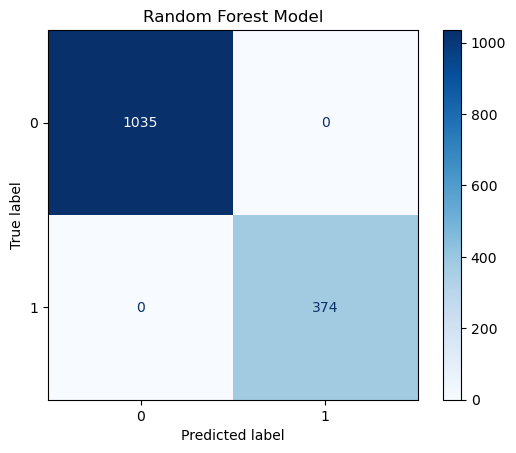

Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


In [48]:
from sklearn.ensemble import RandomForestClassifier

# RandomOverSampler
ros = RandomOverSampler(random_state=42)
x_resampled_ros, y_resampled_ros = ros.fit_resample(x_dev, y_dev)

# initial model
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10,      
    min_samples_split=10,
    min_samples_leaf=5,    
    max_features="sqrt",  
    random_state=42
)

# cross validation
from sklearn.model_selection import cross_validate

scores_rf = cross_validate(
    rf_model,
    x_resampled_ros,
    y_resampled_ros,
    cv=5,
    scoring=['roc_auc', 'average_precision']
)

print("Random Forest CV Results:")
print(f"Mean ROC AUC: {scores_rf['test_roc_auc'].mean():.4f}")
print(f"Mean Average Precision: {scores_rf['test_average_precision'].mean():.4f}")

# model train
rf_model.fit(x_resampled_ros, y_resampled_ros)

# make prediction on development set
y_dev_pred_rf = rf_model.predict(x_resampled_ros)
y_dev_prob_rf = rf_model.predict_proba(x_resampled_ros)[:, 1]

roc_auc_train_rf = roc_auc_score(y_resampled_ros, y_dev_prob_rf)
print(f"\nTraining ROC AUC: {roc_auc_train_rf:.4f}")

print("\nClassification Report on Training Set:")
print(classification_report(y_resampled_ros, y_dev_pred_rf))

# make prediction on test set
y_test_pred_rf = rf_model.predict(x_test)
y_test_prob_rf = rf_model.predict_proba(x_test)[:, 1]

roc_auc_rf = roc_auc_score(y_test, y_test_prob_rf)
print(f"\nTest ROC AUC: {roc_auc_rf:.4f}")

print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred_rf))

# confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_test_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=rf_model.classes_)
disp_rf.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Model")
plt.show()

# performance
precision_rf = precision_score(y_test, y_test_pred_rf, pos_label=0)
recall_rf = recall_score(y_test, y_test_pred_rf, pos_label=0)
f1_rf = f1_score(y_test, y_test_pred_rf, pos_label=0)  

# precision_rf = precision_score(y_test, y_test_pred_rf, pos_label='Churned')
# recall_rf = recall_score(y_test, y_test_pred_rf, pos_label='Churned')
# f1_rf = f1_score(y_test, y_test_pred_rf, pos_label='Churned') 

print(f"Precision: {precision_rf:.4f}, Recall: {recall_rf:.4f}, F1-Score: {f1_rf:.4f}")


### feature importance 
the result from initial model perform very well on development set and test set as the ROC AUC score and confusion matrix are equal to 1. So it might indicate that the model is overfitting. Therfore, we will do feature importance to remove or reevalute the importance of the feature in the model during the training.  

In [49]:
feature_importances = pd.DataFrame({
    'Feature': x_dev.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances.head(10))



                           Feature  Importance
15             Customer Status_ord    0.413099
12          Satisfaction Score_ord    0.200817
2                      Churn Score    0.188982
33       Churn Category_Competitor    0.065297
10                    Contract_ord    0.027847
14         Number of Referrals_ord    0.021836
0                    Tenure Months    0.017260
34  Churn Category_Dissatisfaction    0.014186
36            Churn Category_Price    0.009844
13        Number of Dependents_ord    0.006063


In [50]:
# correlation between top three high importance score features and churn value
correlation_with_target = x_dev[['Customer Status_ord', 'Satisfaction Score_ord', 'Churn Score']].join(y_dev).corr()
print(correlation_with_target['Churn Value'])
      
# print(df[['Churn Category', 'Churn Value']].groupby('Churn Category').mean())


Customer Status_ord      -0.960457
Satisfaction Score_ord   -0.754413
Churn Score               0.659742
Churn Value               1.000000
Name: Churn Value, dtype: float64


In [51]:
# remove high importance feature based on correlation to reduce the risk of overfitting
# remove churn category 1 since its not highly correlated with churn
# x_dev_dropped = x_dev.drop(columns=['Customer Status_ord', 'Churn Score', 'Churn Category_1'])
# x_test_dropped = x_test.drop(columns=['Customer Status_ord', 'Churn Score', 'Churn Category_1']) 

x_dev_dropped = x_dev.drop(columns=['Customer Status_ord', 'Churn Score'])
x_test_dropped = x_test.drop(columns=['Customer Status_ord', 'Churn Score'])


Test ROC AUC: 0.9953370017308637

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1035
           1       1.00      0.92      0.96       374

    accuracy                           0.98      1409
   macro avg       0.99      0.96      0.97      1409
weighted avg       0.98      0.98      0.98      1409



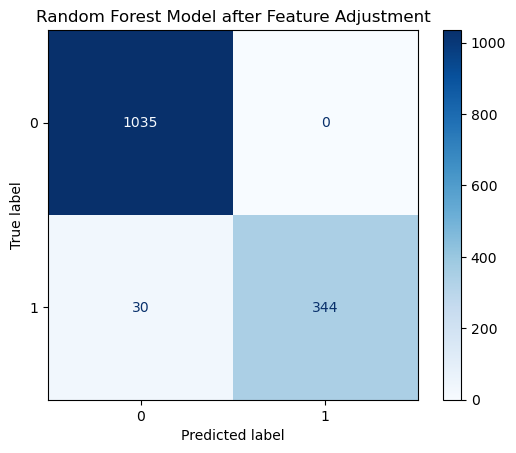

In [52]:
# re-train model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt",
    random_state=42
)

rf_model.fit(x_dev_dropped, y_dev)

# predict test set
y_test_pred_rf = rf_model.predict(x_test_dropped)
y_test_prob_rf = rf_model.predict_proba(x_test_dropped)[:, 1]

print("Test ROC AUC:", roc_auc_score(y_test, y_test_prob_rf))
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred_rf))

# confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_test_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=rf_model.classes_)
disp_rf.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Model after Feature Adjustment")
plt.show()


## Random Forest Model - SMOTE (comparison)

Random Forest with SMOTE Test ROC AUC: 1.0

Classification Report on Test Set (Random Forest with SMOTE):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1035
           1       1.00      1.00      1.00       374

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409



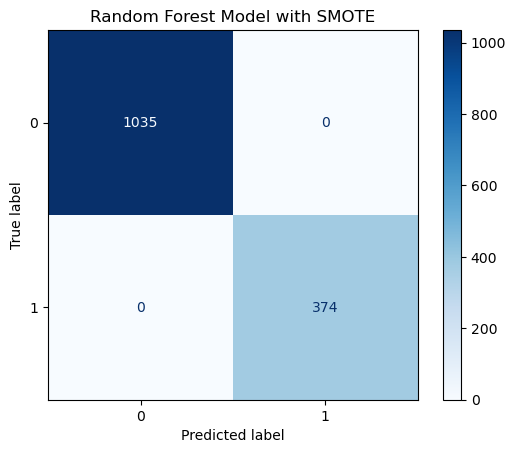

In [53]:
# with smote
smote = SMOTE(random_state=42)
x_resampled_smote, y_resampled_smote = smote.fit_resample(x_dev, y_dev)


rf_smote_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt",
    random_state=42
)

rf_smote_model.fit(x_resampled_smote, y_resampled_smote)

y_test_pred_rf_smote = rf_smote_model.predict(x_test)
y_test_prob_rf_smote = rf_smote_model.predict_proba(x_test)[:, 1]

print("Random Forest with SMOTE Test ROC AUC:", roc_auc_score(y_test, y_test_prob_rf_smote))
print("\nClassification Report on Test Set (Random Forest with SMOTE):")
print(classification_report(y_test, y_test_pred_rf_smote))

conf_matrix_rf_smote = confusion_matrix(y_test, y_test_pred_rf_smote)
disp_rf_smote = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf_smote, display_labels=rf_smote_model.classes_)
disp_rf_smote.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Model with SMOTE")
plt.show()

In [54]:
feature_importances = pd.DataFrame({
    'Feature': x_dev.columns,
    'Importance': rf_smote_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances.head(10))



                           Feature  Importance
15             Customer Status_ord    0.380718
12          Satisfaction Score_ord    0.208298
2                      Churn Score    0.207706
33       Churn Category_Competitor    0.055691
10                    Contract_ord    0.050812
14         Number of Referrals_ord    0.024363
0                    Tenure Months    0.020909
13        Number of Dependents_ord    0.008400
6          Avg Monthly GB Download    0.008374
34  Churn Category_Dissatisfaction    0.006880


 it performance same in random oversampling, so we will use x_dev_dropped and x_test_dropped in other later training

Test ROC AUC after Removing Leak Features: 0.9938670593402051

Classification Report after Removing Leak Features:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1035
           1       0.90      0.96      0.93       374

    accuracy                           0.96      1409
   macro avg       0.94      0.96      0.95      1409
weighted avg       0.96      0.96      0.96      1409



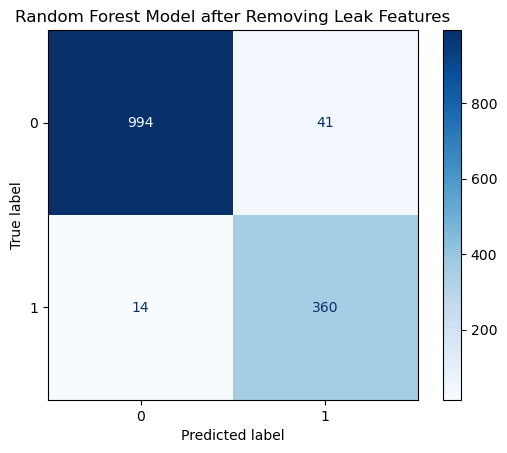

In [55]:
# re- train model

smote = SMOTE(random_state=42)
x_resampled_smote_dropped, y_resampled_smote_dropped = smote.fit_resample(x_dev_dropped, y_dev)

rf_smote_drop_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt",
    random_state=42
)

rf_smote_drop_model.fit(x_resampled_smote_dropped, y_resampled_smote_dropped)

y_test_pred_drop = rf_smote_drop_model.predict(x_test_dropped)
y_test_prob_drop = rf_smote_drop_model.predict_proba(x_test_dropped)[:, 1]

print("Test ROC AUC after Removing Leak Features:", roc_auc_score(y_test, y_test_prob_drop))
print("\nClassification Report after Removing Leak Features:")
print(classification_report(y_test, y_test_pred_drop))

conf_matrix_cleaned = confusion_matrix(y_test, y_test_pred_drop)
disp_cleaned = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_cleaned, display_labels=rf_smote_drop_model.classes_)
disp_cleaned.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Model after Removing Leak Features")
plt.show()

In [56]:
# double check if the model wont highly dependent on one feature
# recalculate the feature importance
feature_importances_smote_drop = pd.DataFrame({
    'Feature': x_dev_dropped.columns,
    'Importance': rf_smote_drop_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances after Removing Leak Features:")
print(feature_importances_smote_drop.head(10))
 

Feature Importances after Removing Leak Features:
                      Feature  Importance
11     Satisfaction Score_ord    0.348279
31  Churn Category_Competitor    0.168567
9                Contract_ord    0.102088
13    Number of Referrals_ord    0.065394
0               Tenure Months    0.052693
1             Monthly Charges    0.037304
12   Number of Dependents_ord    0.036009
19        Online Security_Yes    0.028369
5     Avg Monthly GB Download    0.025542
22           Tech Support_Yes    0.023662


### ROC curve - compared

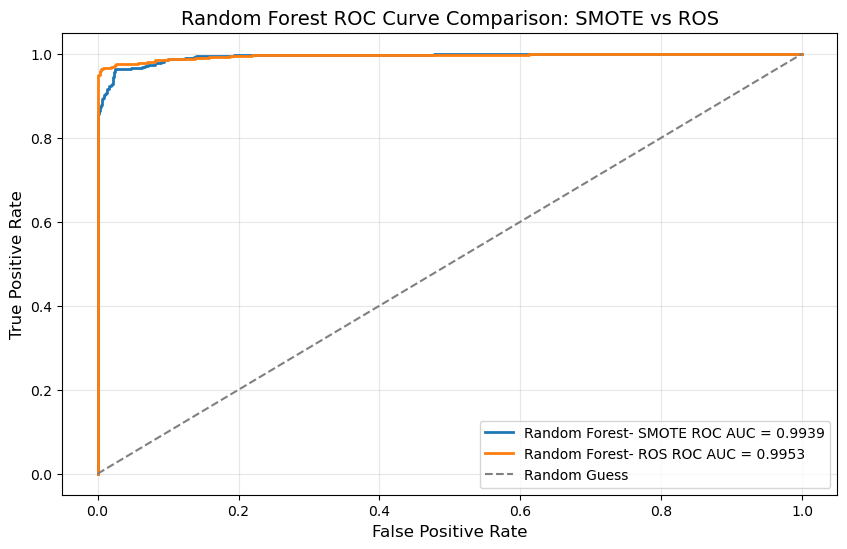

In [57]:

fpr_rf_smote, tpr_rf_smote, _ = roc_curve(y_test, y_test_prob_drop)
roc_auc_rf_smote = auc(fpr_rf_smote, tpr_rf_smote)
fpr_rf_ros, tpr_rf_ros, _ = roc_curve(y_test, y_test_prob_rf)
roc_auc_rf_ros = auc(fpr_rf_ros, tpr_rf_ros)

plt.figure(figsize=(10, 6))
plt.plot(fpr_rf_smote, tpr_rf_smote, label=f"Random Forest- SMOTE ROC AUC = {roc_auc_rf_smote:.4f}", linewidth=2)
plt.plot(fpr_rf_ros, tpr_rf_ros, label=f"Random Forest- ROS ROC AUC = {roc_auc_rf_ros:.4f}", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Random Forest ROC Curve Comparison: SMOTE vs ROS", fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


## XG Boost Model

In [58]:
from sklearn.model_selection import train_test_split


X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    x_dev, y_dev, test_size=0.2, stratify=y_dev, random_state=42
)

print("Train set shape:", X_train_xgb.shape, y_train_xgb.shape)
print("Test set shape:", X_test_xgb.shape, y_test_xgb.shape)

Train set shape: (4507, 37) (4507,)
Test set shape: (1127, 37) (1127,)


In [59]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
y_train_xgb_encoded = label_encoder.fit_transform(y_train_xgb)
y_test_xgb_encoded = label_encoder.transform(y_test_xgb)


print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

{0: 0, 1: 1}


In [60]:
from xgboost import XGBClassifier


xgb_model = XGBClassifier(
    colsample_bytree=0.8,        
    learning_rate=0.05,          
    max_depth=4,                 
    n_estimators=100,            
    reg_alpha=0,                 
    reg_lambda=1,                
    subsample=0.8,               
    use_label_encoder=False,     
    eval_metric="logloss",       
    random_state=42              
)

In [61]:
xgb_model.fit(X_train_xgb, y_train_xgb_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [62]:
from sklearn.metrics import classification_report, roc_auc_score

# Predictions
y_pred_xgb = xgb_model.predict(X_test_xgb)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_xgb)[:, 1]

# Classification Metrics
print("Classification Report:")
print(classification_report(y_test_xgb_encoded, y_pred_xgb))

# AUC-ROC Score
auc_roc = roc_auc_score(y_test_xgb_encoded, y_pred_proba_xgb)
print("AUC-ROC:", auc_roc)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       828
           1       1.00      1.00      1.00       299

    accuracy                           1.00      1127
   macro avg       1.00      1.00      1.00      1127
weighted avg       1.00      1.00      1.00      1127

AUC-ROC: 1.0


In [63]:
correlations = X_train_xgb.corrwith(pd.Series(y_train_xgb_encoded, name="Target")).sort_values(ascending=False)
print("Top Correlated Features with Target:")
print(correlations.head(10))

Top Correlated Features with Target:
Gender_Male                        0.047117
Churn Category_Competitor          0.022670
Churn Score                        0.022358
Monthly Charges                    0.019303
Payment Method_Electronic check    0.018559
CLTV                               0.015548
Device Protection_Yes              0.012389
Contract_ord                       0.011322
Customer Status_ord                0.010008
Tech Support_Yes                   0.009058
dtype: float64


In [64]:
# Remove the potential likage features
linkage_features = ['Number of Dependents_ord','Churn Category_Dissatisfaction', 'Churn Category_Competitor', 'Churn Category_Other']
X_train_xgb = X_train_xgb.drop(columns=linkage_features, errors='ignore')
X_test_xgb = X_test_xgb.drop(columns=linkage_features, errors='ignore')

In [65]:
xgb_model.fit(X_train_xgb, y_train_xgb_encoded)

y_pred_xgb = xgb_model.predict(X_test_xgb)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_xgb)[:, 1]

print("Classification Report After Feature Removal:")
print(classification_report(y_test_xgb_encoded, y_pred_xgb))
print("AUC-ROC After Feature Removal:", roc_auc_score(y_test_xgb_encoded, y_pred_proba_xgb))

Classification Report After Feature Removal:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       828
           1       1.00      1.00      1.00       299

    accuracy                           1.00      1127
   macro avg       1.00      1.00      1.00      1127
weighted avg       1.00      1.00      1.00      1127

AUC-ROC After Feature Removal: 1.0


In [66]:
# checking the feature importance since the model is performing too well

feature_importances = pd.DataFrame({
    'Feature': X_train_xgb.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Top Features After Linkage Features Removal:")
print(feature_importances.head(10))

Top Features After Linkage Features Removal:
                        Feature  Importance
14          Customer Status_ord    0.858416
12       Satisfaction Score_ord    0.091609
2                   Churn Score    0.026529
10                 Contract_ord    0.012975
0                 Tenure Months    0.003178
20          Online Security_Yes    0.002300
13      Number of Referrals_ord    0.002004
1               Monthly Charges    0.001450
9   Total Long Distance Charges    0.000781
6       Avg Monthly GB Download    0.000758


In [67]:
# Check correlation of features with the target
correlations = X_train_xgb.assign(Target=y_train_xgb_encoded).corr()['Target'].sort_values(ascending=False)
print("Correlation of features with target:")
print(correlations.head(10))

Correlation of features with target:
Target                             1.000000
Churn Score                        0.661278
Payment Method_Electronic check    0.308753
Churn Category_Price               0.297911
Monthly Charges                    0.205598
Paperless Billing_Yes              0.196061
Unlimited Data_Yes                 0.168281
Senior Citizen_Yes                 0.166792
Age                                0.127639
Avg Monthly GB Download            0.120168
Name: Target, dtype: float64


In [68]:
# Remove identified linkage features
linkage_features2 = ['Customer Status_ord', 'Satisfaction Score_ord']
X_train_xgb = X_train_xgb.drop(columns=linkage_features2, errors='ignore')
X_test_xgb = X_test_xgb.drop(columns=linkage_features2, errors='ignore')

In [69]:
correlation = X_train_xgb.assign(Target=y_train_xgb_encoded).corr()['Target'].sort_values(ascending=False)
print("Correlation of features with target:")
print(correlation)

Correlation of features with target:
Target                                    1.000000
Churn Score                               0.661278
Payment Method_Electronic check           0.308753
Churn Category_Price                      0.297911
Monthly Charges                           0.205598
Paperless Billing_Yes                     0.196061
Unlimited Data_Yes                        0.168281
Senior Citizen_Yes                        0.166792
Age                                       0.127639
Avg Monthly GB Download                   0.120168
Offer_ord                                 0.110090
Streaming Movies_Yes                      0.077124
Streaming TV_Yes                          0.068678
Multiple Lines_Yes                        0.030864
Phone Service_Yes                         0.020655
Avg Monthly Long Distance Charges         0.018830
Total Extra Data Charges                 -0.006432
Gender_Male                              -0.007273
Total Refunds                            -0.0

In [70]:
xgb_model.fit(X_train_xgb, y_train_xgb_encoded)

y_pred_xgb = xgb_model.predict(X_test_xgb)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_xgb)[:, 1]

print("Classification Report After Further Feature Removal:")
print(classification_report(y_test_xgb_encoded, y_pred_xgb))
print("AUC-ROC After Further Feature Removal:", roc_auc_score(y_test_xgb_encoded, y_pred_proba_xgb))

Classification Report After Further Feature Removal:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       828
           1       0.92      0.89      0.90       299

    accuracy                           0.95      1127
   macro avg       0.94      0.93      0.93      1127
weighted avg       0.95      0.95      0.95      1127

AUC-ROC After Further Feature Removal: 0.990287673888808


In [71]:
# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X_train_xgb.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Top Features After Further Feature Removal:")
print(feature_importances.head(10))

Top Features After Further Feature Removal:
                            Feature  Importance
2                       Churn Score    0.374285
10                     Contract_ord    0.153224
26  Payment Method_Electronic check    0.056633
12          Number of Referrals_ord    0.046073
30             Churn Category_Price    0.042648
0                     Tenure Months    0.040005
1                   Monthly Charges    0.033111
6           Avg Monthly GB Download    0.030417
22                 Streaming TV_Yes    0.023540
18              Online Security_Yes    0.023137


In [72]:
# Remmoving Churn Score since it looks like a leakage feature

linkage_features2.append('Churn Score')
X_train_xgb = X_train_xgb.drop(columns=linkage_features2, errors='ignore')
X_test_xgb = X_test_xgb.drop(columns=linkage_features2, errors='ignore')

In [73]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 1, 10],
    'reg_lambda': [1, 10]
}


xgb_model = XGBClassifier(
    eval_metric="logloss",
    random_state=42
)


grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',  
    cv=3,               
    verbose=2,
    n_jobs=-1           
)


grid_search.fit(X_train_xgb, y_train_xgb_encoded)


print("Best Parameters:", grid_search.best_params_)
print("Best AUC-ROC:", grid_search.best_score_)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=10, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=10, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, r

In [74]:
# Initialize the XGBoost model with the best parameters
xgb_best_model = XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.05,
    max_depth=3,
    n_estimators=200,
    reg_alpha=0,
    reg_lambda=1,
    subsample=0.8,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

In [75]:
xgb_best_model.fit(X_train_xgb, y_train_xgb_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [76]:
from sklearn.metrics import classification_report, roc_auc_score


y_pred_best = xgb_best_model.predict(X_test_xgb)
y_pred_proba_best = xgb_best_model.predict_proba(X_test_xgb)[:, 1]


print("Classification Report for Best Model:")
print(classification_report(y_test_xgb_encoded, y_pred_best))
print("AUC-ROC for Best Model:", roc_auc_score(y_test_xgb_encoded, y_pred_proba_best))

Classification Report for Best Model:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       828
           1       0.77      0.62      0.69       299

    accuracy                           0.85      1127
   macro avg       0.82      0.78      0.79      1127
weighted avg       0.84      0.85      0.84      1127

AUC-ROC for Best Model: 0.9138634417462395


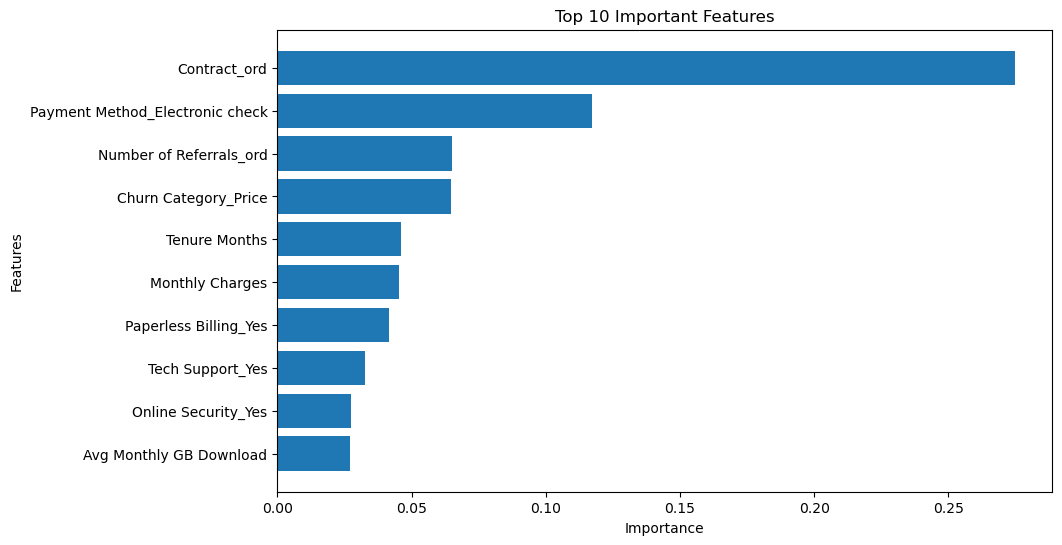

In [77]:
feature_importances_best = pd.DataFrame({
    'Feature': X_train_xgb.columns,
    'Importance': xgb_best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(feature_importances_best['Feature'][:10], feature_importances_best['Importance'][:10])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 10 Important Features')
plt.gca().invert_yaxis()
plt.show()

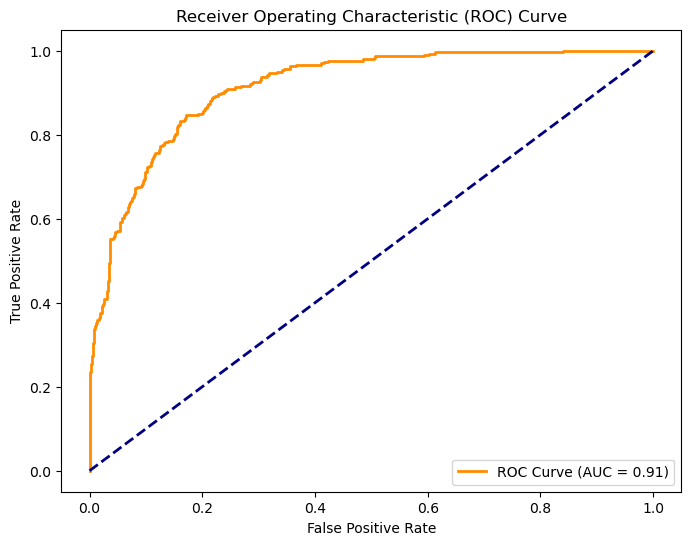

In [78]:
# ROC Curve Plot
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test_xgb_encoded, y_pred_proba_best)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()